In [20]:
import torch
import torchvision
import torchinfo
from torchvision.transforms import v2
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import time

from PIL import Image


import vcpi_util

# Balanceamento do dataset

Olhando para o output da célula abaixo podemos verificar que existem classes muito subpopuladas em relação a outras, pelo que achamos que seria uma mais valia balancear o dataset, adicionando entradas que seriam transformações de outras entradas do dataset.

No final, o dataset balanceado tem 2000 entradas para todas as classes.

Counter({2: 1830, 1: 1801, 13: 1739, 12: 1712, 38: 1639, 14: 1635, 5: 1631, 34: 1630, 41: 1622, 9: 1622, 7: 1617, 31: 1616, 42: 1616, 15: 1616, 26: 1606, 22: 1605, 17: 1605, 3: 1605, 18: 1602, 6: 1601, 33: 1601, 8: 1599, 20: 1599, 19: 1598, 36: 1597, 40: 1597, 23: 1597, 29: 1594, 4: 1589, 24: 1589, 16: 1589, 11: 1587, 39: 1586, 27: 1585, 37: 1584, 21: 1583, 28: 1582, 35: 1580, 25: 1579, 0: 1577, 10: 1571, 32: 1568, 30: 1567})


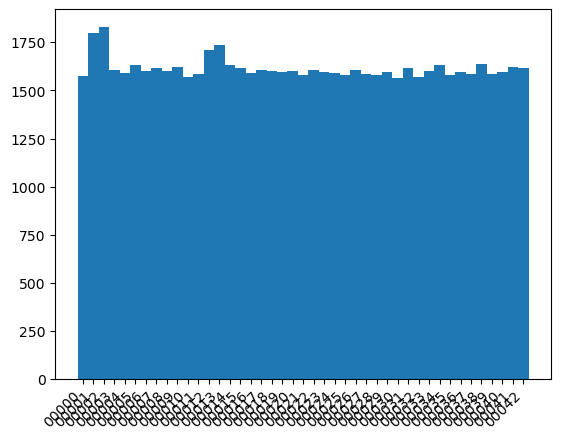

In [21]:
target_list = []
for images, targets in train_loader:
    target_list.extend(targets)

vcpi_util.show_histogram(target_list, train_set.classes)

In [22]:
IMAGES_PER_CLASS = 2000
data_path = 'dataset'


In [23]:
# import random
# from PIL import Image, ImageEnhance
# import random
# import os

# try:
#     os.mkdir(f"{data_path}/train_balanced")
# except:
#     print("Ja tinha folder")
# classes = os.listdir(f'{data_path}/train')

# list_img = []
# for cla in classes:
#     try:
#         os.mkdir(f"{data_path}/train_balanced/{cla}")
#     except:
#         print("Ja tinha folder")
    
#     list_img = [file for file in os.listdir(f'{data_path}/train/{cla}') if ".csv" not in file]
#     random.shuffle(list_img)
    
#     for i in range(len(list_img)):
#         filename = f"{data_path}/train/{cla}/{list_img[i]}"
#         im = Image.open(filename)
        
#         im.save(f"{data_path}/train_balanced/{cla}/{list_img[i]}")
    
#     for k in range(len(list_img), IMAGES_PER_CLASS):

#         filename = f'{data_path}/train/{cla}/{list_img[(k - len(list_img)) % len(list_img)]}'
#         im = Image.open(filename)

#         r = random.uniform(-10.0,10.0)
#         im = im.rotate(r)
#         r1 = random.uniform(-3.0,3.0)
#         r2 = random.uniform(-3.0,3.0)

#         im = im.transform(im.size, Image.Transform.AFFINE, (1, 0, r1, 0, 1, r2))

#         r = random.uniform(1.0, 1.3)
#         im = ImageEnhance.Sharpness(im)
#         im = im.enhance(r)

#         r = random.uniform(1.0, 1.3)
#         im = ImageEnhance.Contrast(im)
#         im = im.enhance(r)
        
#         im = im.resize((32,32))

#         im.save(f'{data_path}/train_balanced/{cla}/_{k}.png')

# Definições Relevantes

Abaixo temos a definição da função de treino para um modelo, que recebe também uma transformação para aplicar dinamicamente às imagens enquanto treina, fazendo assim aumentação do dataset de treino. Temos ainda a definição da função para avaliar um modelo, a definição do modelo em si, do early stopper utilizado para parar mais cedo o treino, e ainda uma função que constrói a matrix de confusão dos resultados do modelo.

In [24]:
def train_III(model, train_loader, val_loader, epochs, loss_fn, optimizer, scheduler, early_stopper, transform: transforms.Compose = None, save_prefix = 'model'):

    history = {}
    history['accuracy'] = []
    history['val_acc'] = []
    history['val_loss'] = []
    history['loss'] = []
    best_val_loss = np.inf

    for epoch in range(epochs):  # loop over the dataset multiple times

        model.train()
        start_time = time.time() 
        correct = 0
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader, 0):
            
            inputs = inputs.to(device)
            targets = targets.to(device)
            # inputs, targets = transform(inputs, targets)
            if transform:
                inputs = transform(inputs)

            outputs = model(inputs)
            # targets = targets.squeeze()
            
            _, predicted = torch.max(outputs, 1)
            # predicted = outputs

            loss = loss_fn(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss
            correct += (predicted == targets).sum()

        model.eval()
        with torch.no_grad():
            v_correct = 0
            val_loss = 0.0
            for i,t in val_loader:
                
                i = i.to(device)
                t = t.to(device)
                if transform:
                    i = transform(i)
                # i,t= transform(i,t)
                o = model(i)
                # t = t.squeeze()
                _,p = torch.max(o,1)
                # p = o
                #with torch.no_grad():
                val_loss += loss_fn(o, t)

                v_correct += (p == t).sum()

        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        
        if old_lr != new_lr:
            print('==> Learning rate updated: ', old_lr, ' -> ', new_lr)

        epoch_loss = running_loss / len(train_loader.dataset)
        accuracy = 100 * correct / len(train_loader.dataset)
        v_accuracy = 100 * v_correct / len(val_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Loss: {epoch_loss:0.6f}; Accuracy: {accuracy:0.4f}; Val Loss: {val_loss:0.6f}; Val Acc: {v_accuracy:0.4f}; Elapsed time: {(stop_time - start_time):0.4f}')
        history['accuracy'].append(accuracy.cpu().numpy())
        history['val_acc'].append(v_accuracy.cpu().numpy())
        history['val_loss'].append(val_loss.cpu().detach().numpy())
        history['loss'].append(epoch_loss.cpu().detach().numpy())
 
        ###### Saving ######
        if val_loss < best_val_loss:
           
            torch.save({
                'epoch': epoch,
                'model':model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
                },
                f'{save_prefix}_best.pt')

        if early_stopper(val_loss):
            print('Early stopping!')
            break
        
    print('Finished Training')

    return(history)


def evaluate(model, data_loader):

    # sets the model in evaluation mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.eval()

    correct = 0
    
    for i, (images, targets) in enumerate(data_loader):
         
        # forward pass, compute the output of the model for the current batch
        outputs = model(images.to(device))

        # "max" returns a namedtuple (values, indices) where values is the maximum 
        # value of each row of the input tensor in the given dimension dim; 
        # indices is the index location of each maximum value found (argmax).
        # the argmax effectively provides the predicted class number        
        _, preds = torch.max(outputs, dim=1)

        correct += (preds.cpu() == targets).sum()

    return (correct / len(data_loader.dataset)).item()


class Conv(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, 3)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.relu1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.relu2 = torch.nn.ReLU()

        self.maxpool1 = torch.nn.MaxPool2d(2)


        self.conv3 = torch.nn.Conv2d(32, 48, 3)
        self.bn3 = torch.nn.BatchNorm2d(48)
        self.relu3 = torch.nn.ReLU()

        self.conv4 = torch.nn.Conv2d(48, 48, 3)
        self.bn4 = torch.nn.BatchNorm2d(48)
        self.relu4 = torch.nn.ReLU()

        self.maxpool2 = torch.nn.MaxPool2d(2)

        self.fc1 = torch.nn.Linear(1200, num_classes)
        

    def forward(self, x):    
        
        # input = (bs, 3, 32, 32)
        x = self.conv1(x) # -> (bs, 16, 30, 30)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x) # -> (bs, 32, 28, 28)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool1(x) # -> (bs, 32, 14, 14)
        
        x = self.conv3(x) # -> (bs, 48, 12, 12)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x) # -> (bs, 48, 10, 10)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.maxpool2(x) # -> (bs, 48, 5, 5)
        
        x = torch.flatten(x,1) # -> (bs, 48 * 5 * 5 = 1200)
        x = self.fc1(x)        # -> (bs, num_classes)

        return(x)



class Early_Stopping():

    def __init__(self, patience = 3, min_delta = 0.00001):

        self.patience = patience 
        self.min_delta = min_delta

        self.min_delta
        self.min_val_loss = float('inf')

    def __call__(self, val_loss):

        # improvement
        if val_loss + self.min_delta < self.min_val_loss:
            self.min_val_loss = val_loss
            self.counter = 0

        # no improvement            
        else:
            self.counter += 1
            if self.counter > self.patience:
                return True
            
        return False
    


def build_confusion_matrix(model, dataset):

    preds = []
    ground_truth = []

    for images, targets in dataset:

        predictions = model(images.to(device))
        preds_sparse = [np.argmax(x) for x in predictions.cpu().detach().numpy()]
        preds.extend(preds_sparse)
        ground_truth.extend(targets.numpy())

    vcpi_util.show_confusion_matrix(ground_truth, preds, len(test_set.classes))      


Decidimos utilizar 32x32 para o tamanho das imagens dentro do modelo, com um _batch size_ de 32.

In [25]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

PATH_TRAINING_SET = 'dataset/train_balanced'
PATH_TEST_SET = 'dataset/test'

BATCH_SIZE = 32

EPOCHS = 30
img_size = 32

cuda:0


Definição de uma transformação que foi utilizada no treino de um modelo, que apenas roda a imagem e apaga parte da mesma, e uma transformação que apenas redimensiona a imagem e a coloca no tipo float.

In [26]:
transform = transforms.Compose([
    v2.ToImage(),
    v2.RandomRotation(50),
    v2.Resize((img_size, img_size)), 
    v2.RandomErasing(0.5, (0.1,0.1)),
    v2.ToDtype(torch.float32, scale=True)
])

transformNormal = transforms.Compose([
    v2.ToImage(),
    v2.Resize((img_size, img_size)), 
    v2.ToDtype(torch.float32)
])

Load dos datasets de treino e de teste, utilizando 80% do dataset de treino para efetivamente treinar o modelo e 20% para validação.

In [27]:
train_set: torchvision.datasets.ImageFolder = torchvision.datasets.ImageFolder(root=PATH_TRAINING_SET, transform = transformNormal)

train_sub_set, val_sub_set = torch.utils.data.random_split(train_set, [0.8, 0.2])

train_loader: torch.utils.data.DataLoader = torch.utils.data.DataLoader(train_sub_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader: torch.utils.data.DataLoader = torch.utils.data.DataLoader(val_sub_set, batch_size=BATCH_SIZE)

test_set: torchvision.datasets.ImageFolder = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform = transformNormal)
test_loader: torch.utils.data.DataLoader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE)



Instanciação do modelo

In [28]:
model = Conv(len(train_set.classes))
model.to(device)
print(model)

torchinfo.summary(model, input_size=(BATCH_SIZE, 3, 32, 32))

Conv(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1200, out_features=43, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Conv                                     [32, 43]                  --
├─Conv2d: 1-1                            [32, 16, 30, 30]          448
├─BatchNorm2d: 1-2                       [32, 16, 30, 30]          32
├─ReLU: 1-3                              [32, 16, 30, 30]          --
├─Conv2d: 1-4                            [32, 32, 28, 28]          4,640
├─BatchNorm2d: 1-5                       [32, 32, 28, 28]          64
├─ReLU: 1-6                              [32, 32, 28, 28]          --
├─MaxPool2d: 1-7                         [32, 32, 14, 14]          --
├─Conv2d: 1-8                            [32, 48, 12, 12]          13,872
├─BatchNorm2d: 1-9                       [32, 48, 12, 12]          96
├─ReLU: 1-10                             [32, 48, 12, 12]          --
├─Conv2d: 1-11                           [32, 48, 10, 10]          20,784
├─BatchNorm2d: 1-12                      [32, 48, 10, 10]          96
├─R

Definição do optimizer, scheduler, loss_fn e early_stop utilizados para treinar o modelo.

Temos ainda a definição de algumas transformações, 5 para ser exato.

* transform - Aplicação de uma rotação aleatória entre 0 e 50 graus, redimensionamento e apagar parte da imagem
* transform2 - Redimensionamento da imagem e permutação dos canais da cor, afetando apenas a cor das imagens
* transform3 - Espelhar a imagem horizontalmente (com 50% de chance), espelhar a imagem verticalmente (com 50% de chance), mudar a perspetiva da imagem e aplicar uma transformação "affine"
* transform4 - chance aleatória entre um cutmix ou um mixup de imagens 

In [29]:
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience=3)
loss_fn = torch.nn.CrossEntropyLoss()

early_stop = Early_Stopping(9)

transform2 = transforms.Compose([
    v2.ToImage(),
    v2.Resize((img_size, img_size)), 
    v2.RandomChannelPermutation(),
    v2.ToDtype(torch.float32, scale=True)
])

transform3 = transforms.Compose([
    v2.ToImage(),
    v2.RandomHorizontalFlip(0.5),
    v2.RandomVerticalFlip(0.5),
    v2.RandomPerspective(0.5),
    v2.RandomAffine(50),
    v2.Resize((img_size, img_size)), 
    v2.ToDtype(torch.float32, scale=True)
])


cutmix = v2.CutMix(num_classes=len(train_set.classes))
mixup = v2.MixUp(num_classes=len(train_set.classes))
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup], [0.5, 0.5])

transform4 = transforms.Compose([
    v2.ToImage(),
    v2.Resize((img_size, img_size)), 
    v2.ToDtype(torch.float32, scale=True),
    cutmix_or_mixup
])

transform = transforms.Compose([
    v2.ToImage(),
    v2.RandomRotation(50),
    v2.Resize((img_size, img_size)), 
    v2.RandomErasing(0.5, (0.1,0.1)),
    v2.ToDtype(torch.float32, scale=True)
])

Código utilizado para ler modelos salvos no disco

In [30]:
###### Loading ######
# recreate the model and optimizer
model = Conv(len(train_set.classes))
optimizer = torch.optim.Adam(model.parameters())

#load the dict
retrieved = torch.load(f'rrotateEraseDynamic.pt')

# set the model and optimizer state to the saved state
model.load_state_dict(retrieved['model'])
model.to(device)
optimizer.load_state_dict(retrieved['optimizer'])

Treinar o modelo

In [31]:
history = train_III(model, train_loader, val_loader, EPOCHS, loss_fn, optimizer, scheduler, early_stop, None, 'balanced')

Epoch: 000; Loss: 0.006688; Accuracy: 94.9891; Val Loss: 0.006714; Val Acc: 94.9315; Elapsed time: 56.7357
Epoch: 001; Loss: 0.006684; Accuracy: 94.9646; Val Loss: 0.006720; Val Acc: 94.9027; Elapsed time: 49.8142
Epoch: 002; Loss: 0.006670; Accuracy: 95.0251; Val Loss: 0.006560; Val Acc: 95.0006; Elapsed time: 49.8561
Epoch: 003; Loss: 0.006693; Accuracy: 94.9790; Val Loss: 0.006623; Val Acc: 95.0524; Elapsed time: 48.5514
Epoch: 004; Loss: 0.006685; Accuracy: 94.9473; Val Loss: 0.006664; Val Acc: 94.9603; Elapsed time: 49.6429
Epoch: 005; Loss: 0.006691; Accuracy: 94.9675; Val Loss: 0.006537; Val Acc: 95.0582; Elapsed time: 49.6584
Epoch: 006; Loss: 0.006656; Accuracy: 94.9833; Val Loss: 0.006649; Val Acc: 95.0755; Elapsed time: 50.3485
Epoch: 007; Loss: 0.006632; Accuracy: 95.0639; Val Loss: 0.006618; Val Acc: 95.0524; Elapsed time: 50.1185
Epoch: 008; Loss: 0.006664; Accuracy: 94.9574; Val Loss: 0.006642; Val Acc: 95.0236; Elapsed time: 50.1283
Epoch: 009; Loss: 0.006636; Accuracy:

Avaliar o modelo

In [32]:
evaluate(model, test_loader)

0.975771963596344

# Ensemble

Primeiramente começamos por fazer a leitura dos modelos para serem utilizados no ensemble.

Decidimos de todos os modelos apenas utilizar os melhores, e ignorar os que tem \<90% de accuracy

In [33]:
import os

models = []
acc = []

i = 0
for f in os.listdir():
    
    # if ".pt" in f and f not in ["rotateErase_30.pt", "rrotateErase_49.pt", "cutmixMixup.pt", "cutmixMixup43.pt"]:
    if ".pt" in f and "Balanced" in f:
        print(f)

        reload = torch.load(f)
        model = Conv(len(test_set.classes))
        model.load_state_dict(reload['model'])
        model.to(device)
        models.append(model)
        acc.append(evaluate(models[i], test_loader))
        i += 1


rrotateEraseDynamic.pt
rrotateEraseBalanced.pt
randomChannelPermutBalanced.pt
horveraffineperspectiveNovo.pt
cutmixMixup57.pt


KeyboardInterrupt: 

Gráfico de barras que mostra a avaliação de cada um dos modelos

Podemos verificar que nem todos os modelos utilizados tem as melhores percentagens

Isso é devido ao facto de apenas conseguirmos treinar um dos modelos com o dataset balanceado (randomChannelPermutBalanced), e ao facto de algumas das transformacoes utilizadas não serem ótimas para treinar a rede, que seria o caso da combinação de randomRotate com RandomErase, que, talvez por cortar parte da imagem, com o treino que lhe demos não conseguiu extrair das imagens de input o melhor resultado.

[0.9758511185646057, 0.9780681133270264, 0.9060965776443481, 0.9765637516975403, 0.9570863246917725, 0.9140934348106384, 0.9774346947669983]
0.9550277165004185 0.9780681133270264 0.9060965776443481


(0.8, 1.0)

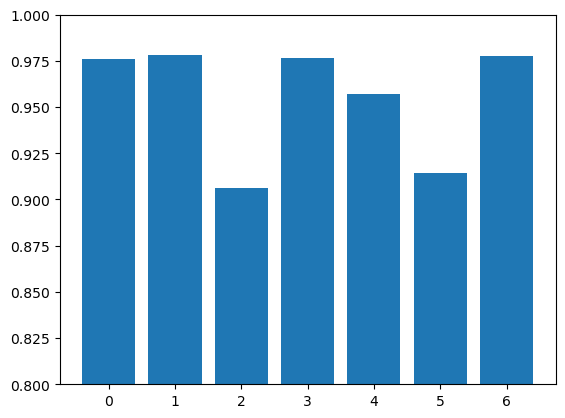

In [ ]:
print(acc)
index = [i for i in range(len(models))]

plt.bar(index, acc)
print(np.mean(acc), np.max(acc), np.min(acc))
plt.ylim(0.80,1.0)

In [ ]:

def get_labels_logits_and_preds(models):

    with torch.no_grad():
        logits = [[] for _ in range(len(models))]
        labels = []

        for images, labs in test_loader:

            images = images.to(device)
            labels.extend(labs)
            
            for i in range(len(models)):
                logits[i].extend(models[i](images).cpu())


    return labels, logits

labels, logits = get_labels_logits_and_preds(models)

In [ ]:
preds = [[] for _ in range(len(labels)) ]
for index in range(len(labels)):
    preds[index] = [np.argmax(logits[m][index].cpu().numpy()) for m in range(len(models))]

In [ ]:
def get_class_from_sum_of_logits(logits):

    sum_logits = []

    for i in range(len(logits[0])):

        log = logits[0][i]
        for m in range(len(models)):
            log = np.add(log, logits[m][i])
        sum_logits.append(np.argmax(log))
    return(sum_logits)
    
class_logits = get_class_from_sum_of_logits(logits)    

## Análise dos resultados do modelo de ensemble


Olhando para os resultados abaixo, podemos ver que, com modelos cuja a melhor classificação era 97.8%, o ensemble desses modelos conseguiu uma percentagem de acerto de 98.6%, o que é um aumento ainda considerável.

Podemos verificar que há casos em que todos acertam, que é a maioria, o que seria de esperar utilizando modelos com accuracy's acima dos 90%.

Temos 1 caso no qual erram todos, 1592 casos com maioria a acertar, 73 empates e  103 com maioria errada.

In [ ]:
import collections 

def get_stats(labels, class_preds, class_logits):

    all_correct = 0
    all_incorrect = 0
    maj_vote = 0
    maj_wrong = 0
    tie = 0
    count = 0

    for k in range(len(labels)):

        counter = collections.Counter(class_preds[k])
        if len(counter) == 1:
            if counter.most_common(1)[0][0] == labels[k]:
                all_correct += 1
            else:
                all_incorrect += 1
        else:
            aux = counter.most_common(2)
            if aux[0][1] > aux[1][1] and aux[0][0] == labels[k]:
                maj_vote += 1
            if aux[0][1] > aux[1][1] and aux[0][0] != labels[k]:
                maj_wrong += 1
            elif aux[0][1] == aux[1][1]:
                tie += 1

        count += 1 
        
    return [count, all_correct, all_incorrect, maj_vote, tie, maj_wrong]
    
    
res = get_stats(labels, preds, class_logits)
print('total: ', res[0])
print('All correct: ', res[1])
print('All incorrect: ', res[2])
print('Majority correct: ', res[3])
print('Tie Vote: ', res[4])
print('Majority Wrong: ', res[5])
print('Percentage right: ', (res[1]+res[3])/res[0])

total:  12630
All correct:  10861
All incorrect:  1
Majority correct:  1592
Tie Vote:  73
Majority Wrong:  103
Percentage right:  0.9859857482185274


# Conclusão

Estamos satisfeitos com os resultados obtidos, uma vez que conseguimos uma taxa de acerto de 98.6%, no entanto sabemos que, se tivéssemos conseguido treinar mais modelos com o dataset já balanceado, conseguiríamos provavelmente aumentar mais esse valor.